In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import glob


In [ ]:
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/"
gam_path = "/home/haue/repositories/Masters/data/gamma/Al/withoutbeta/"

#outputdir = "/figure_output/"
## Load in all files from the datapath with the suffix mlio.root
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
gam_files = glob.glob(os.path.join(gam_path, "*mlio.root"))

#Files to be analyzed 
Analysis_files = gam_files


In [ ]:
# Define gamma gates and their background regions
peak_gates = {
    "1887": [(1855,1900), (1810, 1855), (1900, 1945)]
    # can add more gates...
}

# Initialize storage for results
galphas = {}
region_labels = ["gate", "lower_bg", "upper_bg"]

for gate_name, peak_ranges in peak_gates.items():
    Elist_1 = [np.array([]) for _ in peak_ranges]
    Elist_2 = [np.array([]) for _ in peak_ranges]

    for i, (low, high) in enumerate(peak_ranges):
        
        for batch in uproot.iterate(Analysis_files, expressions=["E"],
            cut=f"(pg1) & (Eg1>{low}) & (Eg1<{high})"):
            Elist_1[i] = np.append(Elist_1[i], ak.flatten(batch.E))

        for batch in uproot.iterate(Analysis_files, expressions=["E"],
            cut=f"(pg2) & (Eg2>{low}) & (Eg2<{high})"):
            Elist_2[i] = np.append(Elist_2[i], ak.flatten(batch.E))

    # Clean and combine
    Elist_1 = [arr[~np.isnan(arr)] for arr in Elist_1]
    Elist_2 = [arr[~np.isnan(arr)] for arr in Elist_2]
    Elist = [np.concatenate((a1, a2)) for a1, a2 in zip(Elist_1, Elist_2)]

    # Store in dictionary with semantic labels
    galphas[gate_name] = {
        region_labels[i]: Elist[i] for i in range(len(region_labels))
    }
    print(f"Gate: {gate_name} processed succesfully!")

Gate: 1887 processed successfully!


In [14]:
"""
### Single proton spectra
E = np.array([])
for batch in uproot.iterate(Al_files, expressions=["E"],
                            cut="(id<4) & (id>0)"):
    E=np.append(E, ak.flatten(batch.E))
"""

'\n### Single proton spectra\nE = np.array([])\nfor batch in uproot.iterate(Al_files, expressions=["E"],\n                            cut="(id<4) & (id>0)"):\n    E=np.append(E, ak.flatten(batch.E))\n'

In [4]:
####plotter function

def plot_energy_hists(
    energies_list,          # list of arrays of energies (in eV)
    reference_overlay=None, # overlay of comparison spectra
    colors=None,            # list of colors matching energies_list
    labels=None,            # list of labels matching energies_list
    bin_width=0.01,         # bin width in MeV
    scale=None,
    title="Energy Histogram",
    xlabel="Energy (MeV)",
    ylabel="default",
    xlim=(0.25, 8.5),
    fig_ax=None             # optionally pass existing (fig, ax)
):
    """
    Plot one or more energy histograms on the same figure with consistent formatting.

    Parameters:
    - energies_list: list of np.arrays, each containing energies (in eV)
    - colors: list of color strings (same length as energies_list), default black if None
    - labels: list of labels (same length as energies_list), default None (no legend)
    - bin_width: float, bin width in MeV
    - title, xlabel, ylabel: strings for the plot
    - xlim: tuple, x-axis limits
    - fig_ax: tuple (fig, ax) if you want to add to existing plot, else None to create new

    Returns:
    - fig, ax: matplotlib figure and axis objects
    """
    bins = np.arange(0, 9 + bin_width, bin_width)
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(16, 7))
    else:
        fig, ax = fig_ax
    
    if colors is None:
        colors = ['k'] * len(energies_list)
    if labels is None:
        labels = [None] * len(energies_list)
    
    for energies, color, label in zip(energies_list, colors, labels):
        ax.hist(np.array(energies) / 1e3, bins=bins, histtype='step',
                edgecolor=color, color='white', lw=1, label=label)
    
    if reference_overlay is not None:
        overlay_bins = np.arange(0, 9 + 0.01, 0.01)  # fixed 10 keV bins (0.01 MeV)
        ref_hist, ref_edges = np.histogram(np.array(reference_overlay) / 1e3, bins=overlay_bins)
        ref_hist = ref_hist.astype(float)
        ref_max = ref_hist.max()

        # Find max count from main histograms (already computed as global_max later, but for clarity compute here)
        main_max = max([np.histogram(np.array(e) / 1e3, bins=bins)[0].max() for e in energies_list])

        if ref_max > 0:
            # Scale reference histogram only if main max < 1e2
            if main_max < 1e3:
                scale_factor = 1e3 / ref_max
            else:
                scale_factor = main_max / ref_max
            ref_hist_scaled = ref_hist * scale_factor

            ref_bin_centers = (ref_edges[:-1] + ref_edges[1:]) / 2
            ax.plot(ref_bin_centers, ref_hist_scaled, color='magenta', ls='--', label='Overlay (scaled)', linewidth=1)

            
    ax.set_yscale('log')
    ax.set_xticks(np.arange(0, 8.5, 0.25), minor=True)
    ax.set_xticks(np.arange(0, 8.5, 1))
    ax.set_xlim(*xlim)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=16)
    plt.tick_params(axis='y', which='major', direction='in', length=5, width=1, labelsize=14)
    plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
    plt.tick_params(axis='x', which='major', direction='in', length=5, width=1, labelsize=14)
    plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
    
    if ylabel=="default":
        ax.set_ylabel(f"Counts / {int(bin_width*1000)} keV", fontsize=16)
    else:
        ax.set_ylabel(ylabel, fontsize=16)
    global_max = 0
    for energies in energies_list:
        hist, _ = np.histogram(np.array(energies) / 1e3, bins=bins)
        current_max = hist.max()
        if current_max > global_max:
            global_max = current_max

    # Set log scale and y-limits AFTER main histograms, BEFORE overlay
    ax.set_yscale("log")
    if scale!=None:
        ymax = max(global_max, scale)*1.1
    else:
        ymax = max(global_max, 1e3) * 1.1  # Use at least 1e2, scaled a bit
    ax.set_ylim(1,ymax)
    if any(labels):
        ax.legend()
    
    return fig, ax


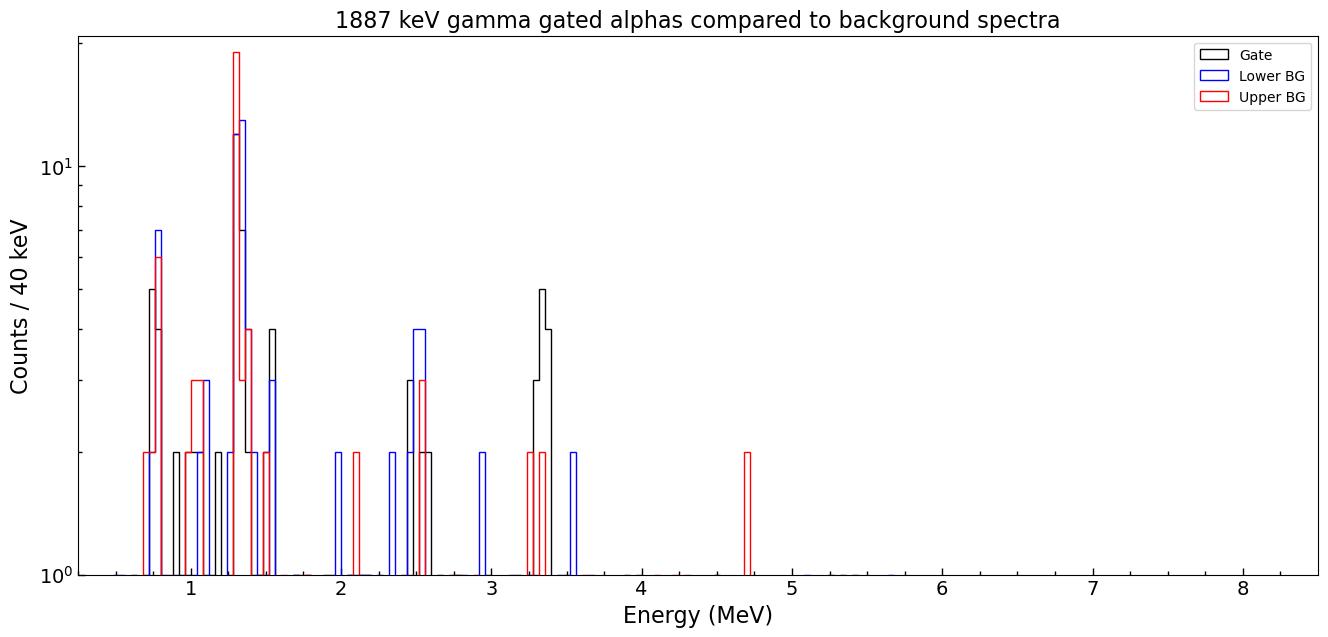

In [ ]:
a = 1887
fig, ax = plot_energy_hists(
    energies_list=[galphas[f"{a}"]["gate"], galphas[f"{a}"]["lower_bg"], galphas[f"{a}"]["upper_bg"]],
    reference_overlay = None,
    colors=['k', 'b', 'r'],
    labels=['Gate', 'Lower BG', 'Upper BG'],
    bin_width=0.04,
    scale=10,
    title=f"{a} keV gamma gated alphas compared to background spectra",
)
plt.show()